<a href="https://colab.research.google.com/github/kishore779/Titanic_pred/blob/main/Titanic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
titanic_data = pd.read_csv('train.csv')

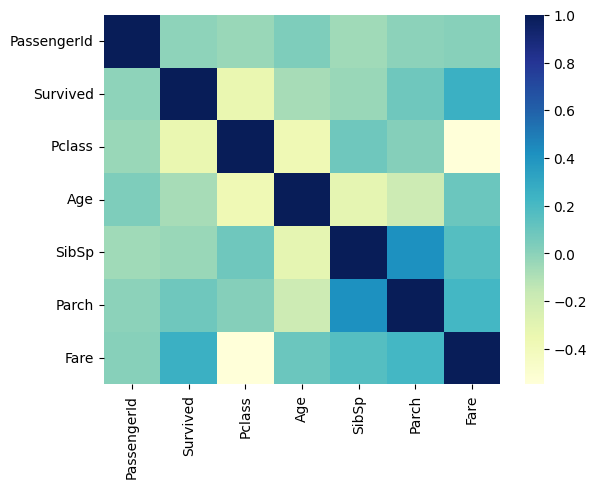

In [ ]:
import seaborn as sns

sns.heatmap(titanic_data.corr(numeric_only=True), cmap = "YlGnBu")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
  start_train_set = titanic_data.loc[train_index]
  start_test_set = titanic_data.loc[test_index]

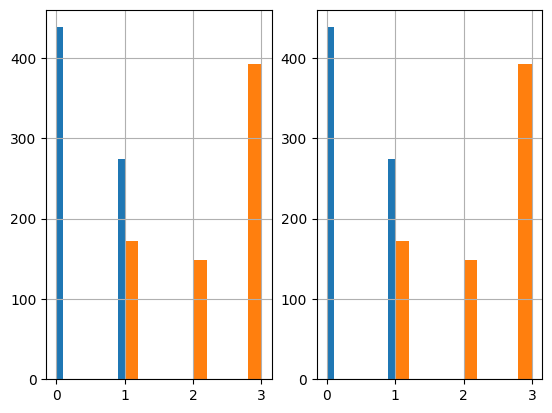

In [ ]:
plt.subplot(1,2,1)
start_train_set['Survived'].hist()
start_train_set['Pclass'].hist()

plt.subplot(1,2,2)
start_train_set['Survived'].hist()
start_train_set['Pclass'].hist()
plt.show()

In [ ]:
start_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 808 to 360
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          579 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    imputer = SimpleImputer(strategy="mean")
    X['Age'] = imputer.fit_transform(X['Age'].values.reshape(-1, 1)) # Reshape for SimpleImputer
    return X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self;

  def transform(self, X):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[['Embarked']]).toarray()
    column_names = ["C","S","Q","N"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['Sex']]).toarray()

    column_names = ["Female", "Male"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    return X

In [ ]:
class FeatureDropper(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")


In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()), ("featureencoder", FeatureEncoder()), ("featuredropper", FeatureDropper())])

In [ ]:
start_train_set = pipeline.fit_transform(start_train_set)

In [ ]:
start_test_set = pipeline.transform(start_test_set)

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler

X = start_train_set.drop(['Survived'], axis =1)
y = start_train_set['Survived']

scalar = StandardScaler()
X_data = scalar.fit_transform(X)
y_data = y.to_numpy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators" : [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
final_clf = grid_search.best_estimator_

In [ ]:
final_clf

RandomForestClassifier(max_depth=10)

In [ ]:
X_test = start_test_set.drop(['Survived'], axis=1)
y_test = start_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [ ]:
final_clf.score(X_data_test, y_data_test)
#

0.7932960893854749

In [ ]:
final_data = pipeline.fit_transform(titanic_data)

In [ ]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [ ]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scalar.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [ ]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators" : [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final ,y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
prod_final_clf = grid_search.best_estimator_

In [ ]:
titanic_test_data = pd.read_csv("test.csv")

In [ ]:
final_test_data = pipeline.transform(titanic_test_data)

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

/tmp/ipython-input-1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [ ]:
predictions = prod_final_clf.predict(X_data_final_test)

In [ ]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("submission.csv", index=False)

In [ ]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
